In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pymoo.indicators.hv import HV
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

In [ ]:
plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
minimal_font_size = 15
plt.rcParams['font.size'] = minimal_font_size
axisfont = {'family': 'Times New Roman', 'weight': 'bold', 'size': 18}
tickfont = {'labelfontfamily': 'Times New Roman', 'labelsize': minimal_font_size}
legendfont = {'family': 'Times New Roman', 'weight': 'normal', 'size': minimal_font_size}

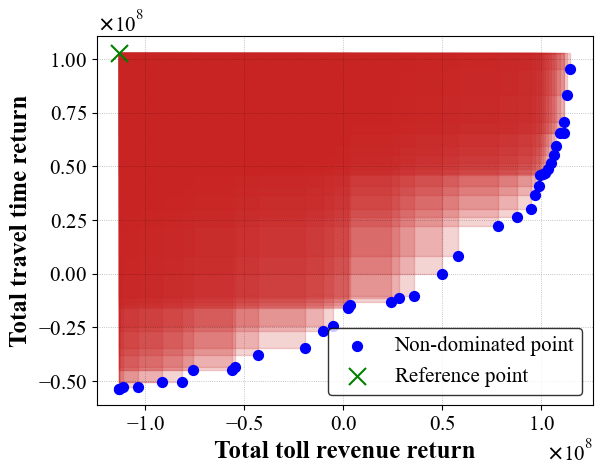

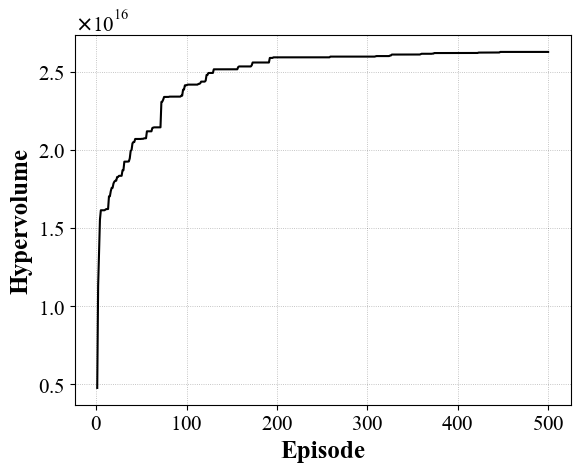

In [ ]:
def hypervolume_evolution(time, toll, normalize=False):
    assert len(time) == len(toll)

    # 转换为 minimization 问题
    points = np.column_stack([time, -toll])

    # ====== Min-Max 归一化 ======
    if normalize:
        min_vals = np.min(points, axis=0)
        max_vals = np.max(points, axis=0)
        # 避免除零
        denom = np.where(max_vals - min_vals == 0, 1, max_vals - min_vals)
        points = (points - min_vals) / denom

    # ====== 超体积随 episode 演化 ======
    # 参考点 (必须比所有点都差)
    ref_point = np.max(points, axis=0) + 1e-6
    front = None
    hvs = []
    for k in range(1, len(points) + 1):
        subset = points[:k]
        # 计算 Pareto 前沿
        front_idx = NonDominatedSorting().do(subset, only_non_dominated_front=True)
        front = subset[front_idx]
        # TODO: 绘图时，将toll的正负转换回来
        # sorted_front = front[front[:, 1].argsort()]  # sorted by toll
        # if k % 500 == 0:
        #     print(k, len(front))
        #     plt.scatter(-ref_point[1], ref_point[0], color='green', marker='x', s=80, label="Reference Point")
        #     plt.scatter(-subset[:, 1], subset[:, 0], label='All Episodes')
        #     plt.plot(-sorted_front[:, 1], sorted_front[:, 0], color='red', label='Pareto Front')
        #     plt.xlabel('Total Toll Revenue Return')
        #     plt.ylabel('Total Travel Time Return')
        #     plt.legend(loc='lower right')
        #     plt.show()

        # 超体积计算
        hv_indicator = HV(ref_point=ref_point)
        hv = hv_indicator(front)
        hvs.append(hv)

    return np.array(hvs), front, ref_point


def plot_hypervolume_area(pareto_points: np.ndarray, ref_point: np.ndarray):
    # 分离目标
    f1 = -pareto_points[:, 1]
    f2 = pareto_points[:, 0]

    # 创建图
    fig, ax = plt.subplots(figsize=(6.4, 4.8))

    # 画超体积矩形
    for y, x in pareto_points:  # 不包含参考点
        rect = patches.Rectangle(
            (-x, y),
            -ref_point[1] + x,
            ref_point[0] - y,
            color='#c82423',
            alpha=0.2  # 透明度叠加
        )
        ax.add_patch(rect)

    # 画 Pareto 前沿点
    ax.scatter(f1, f2, color='blue', s=50, label='Non-dominated point')
    # 画参考点
    ax.scatter(-ref_point[1], ref_point[0], color='green', marker='x', s=150, label='Reference point')

    # 坐标轴和标题
    # ax.set_xlim(0, ref_point[0]+0.1)
    # ax.set_ylim(0, ref_point[1]+0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(-3, 4), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3), useMathText=True)
    ax.set_xlabel('Total toll revenue return', axisfont)
    ax.set_ylabel('Total travel time return', axisfont)
    ax.tick_params(axis='both', which='both', **tickfont)
    # ax.set_title(f'Hypervolume Area', fontsize=15)
    plt.grid(ls=':', alpha=0.3, lw=0.6, color='k')
    plt.legend(loc="lower right", edgecolor='k', prop=legendfont)
    plt.savefig("hypervolume_area.png", bbox_inches='tight', dpi=600)
    plt.show()


# ========== 示例使用 ==========
if __name__ == "__main__":
    data = pd.read_csv("outputs/2025-10-17 23-53-02/stat.csv")
    # data = pd.read_csv("outputs/stat.csv")
    time = np.array(data["ttt"].to_list()) - 38079.6759227694 * 3600
    toll = np.array(data["ttr"].to_list()) - 179131.53562351898 * 1000
    # 不归一化
    hvs_raw, front, ref_point = hypervolume_evolution(time, toll, normalize=False)
    plot_hypervolume_area(front, ref_point)
    # # 归一化
    # hvs_norm, front, ref_point = hypervolume_evolution(time, toll, normalize=True)
    # 绘制对比
    # plt.figure(figsize=(9, 6))
    plt.plot(range(1, len(hvs_raw) + 1), hvs_raw, label="Raw HV", color='black')
    # plt.plot(range(1, len(hvs_norm) + 1), hvs_norm, label="Normalized HV")

    plt.ticklabel_format(style='sci', axis='x', scilimits=(-3, 4), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3), useMathText=True)
    plt.xlabel("Episode", axisfont)
    plt.ylabel("Hypervolume", axisfont)
    plt.tick_params(axis='both', which='both', **tickfont)
    plt.grid(ls=':', alpha=0.3, lw=0.6, color='k')

    # plt.legend()
    plt.savefig("hypervolume_evolutione_curve.png", bbox_inches='tight', dpi=600)
    plt.show()